# LeNet5

This notebook makes use of numpy, matplotlib.pyplot and tensorflow (v 2.0).
In order to run it, I recomment to create a virtual environment and install those packages (or instead, use a cloud environment like Google Colab). It's important to install Tensorflow 2.0 (it won't work on lower versions).

Feel free to download the original notebook this page to play with it!
You will find it together with the necessary resources to run it under:
https://github.com/Martiiiin/sample-ml-projects/tree/master/lenet5

## INSTRUCTIONS

1. Upload to local directory the files __utils.py__ (custom utility functions), and __digits.idx3-ubyte__ (the weights for the ouput layer of the model, implemented as a gaussian connections layer).

2. Modify properly the variables __data_path_drive__ or __data_path_drive__ (depending on where you want the code to execute, whether in your own computer or in Google Colab). You shoud set that variables to a string specifying the folder where you store the MNIST dataset (in idx format, as specified in http://yann.lecun.com/exdb/mnist/ . Also set "environment" to either __LOCAL__ or __CLOUD__.

2. Execute cell by cell.

## Author: Martín Prieto Aguilera

In [1]:
# update TensorFlow (execute only if the version is lower than 2.0)
!pip install --upgrade tensorflow

     |████████████████████████████████| 516.2MB 31kB/s 
  Found existing installation: tensorflow 2.2.0rc4
    Uninstalling tensorflow-2.2.0rc4:
      Successfully uninstalled tensorflow-2.2.0rc4


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import utils

# IMPORTANT: Set "environment" variable to "LOCAL" for running in local and "CLOUD" for running in Colab.
environment = "CLOUD"
data_path_local = "../../data/MNIST_digits"
data_path_drive = "drive/My Drive/TFM/MNIST_digits"

assert ((environment == "LOCAL") | (environment == "CLOUD"))
if environment == "LOCAL":
    data_path = data_path_local
else:
    data_path = data_path_drive
    from google.colab import drive
    drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


X_train shape:  (60000, 28, 28, 1)
X_test shape:  (10000, 28, 28, 1)
t_train shape:  (60000,)
t_test shape:  (10000,)


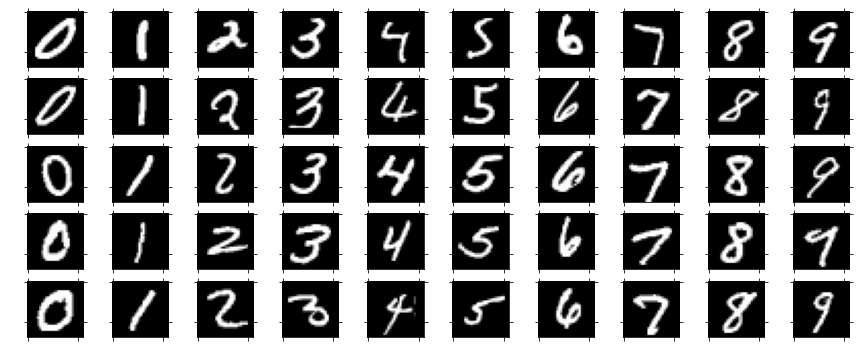

In [4]:
# Load dataset
X_train, X_test, t_train, t_test = utils.fetch_mnist_digit_data(data_path)

# Rescale data to [0,1]
X_train = X_train/255
X_test = X_test/255

# Obtain OneHotEncoded versions of t_train and t_test
T_train = utils.one_hot_encode(t_train).astype(np.float32)
T_test = utils.one_hot_encode(t_test).astype(np.float32)

# Sanity check
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("t_train shape: ", t_train.shape)
print("t_test shape: ", t_test.shape)

# Show a sample of images of each class
n_obs_each_class = 5
selector = np.random.randint(100, size=n_obs_each_class)
fig, ax = plt.subplots(nrows=n_obs_each_class, ncols=10, figsize=(15,6))
for j in range(10):
    selector_for_class = t_train == j
    sample_for_class = X_train[selector_for_class,:,:,:]
    for i in range(n_obs_each_class):
        k = selector[i]
        ax[i,j].imshow(sample_for_class[k,:,:,0], cmap='gray')
        ax[i,j].tick_params(labelcolor='none', which='both', top='off', bottom='off', left='off', right='off')

In [5]:
# Pad images to 32 x 32
X_train = np.pad(X_train, [(0,0), (2,2), (2,2), (0,0)]).astype(np.float32)
X_test = np.pad(X_test, [(0,0), (2,2), (2,2), (0,0)]).astype(np.float32)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (60000, 32, 32, 1)
X_test shape:  (10000, 32, 32, 1)


# Load weights for gaussian connections

LeNet5 doesn't use the classical softmax activation units. Instead, the output neurons compute the distance between the last dense layer output and each of the columns of a static weight matrix (static because it doesn't update across the training procedure).

Each column in this weight matrix represents a digit drawn on a 12x7 canvas, scaled to the range __[-1, 1]__ (to match the output range of the hyperbolic tangent) and flattened.

We shall visualize such weights in the next cell.

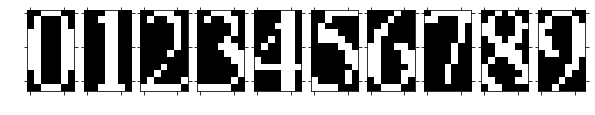

In [6]:
digits_path = "digits.idx3-ubyte"
digits = utils.read_idx_ubyte(digits_path)

fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(10,5))
for i in range(digits.shape[0]):
    ax[i].imshow(digits[i,:,:], cmap='gray')
    ax[i].tick_params(labelcolor='none', which='both', top='off', bottom='off', left='off', right='off')

In [7]:
# Scale digits to range [-1,1]
digits = digits.astype(np.float32)
digits = digits/255 * 2 - 1
digits = digits.reshape((10,84)).T
print(digits.shape)

(84, 10)


## Custom layer design (PartialConnectionsConv2D)
* The of the constructor will be:
1. __connections__: a dictionary in which the key will index an ouput feature and the corresponding value will be a list with the indices of input features that generate it.
2. __kernel_size__: a tuple of 2 ints specifiying the height and width of the 2D convolution window.
3. __strides__ a tuple of 2 integers specifying the strides along height and width during the convolution operation.
4. __activation__: the activation function. Defaults to None (wich will perform linear identity activation)

How will it work?
* All the weights and biases will be declared and initialized in the constructor. In order to know the 3-rd dimension of the weight tensors, we need to count the feature maps (lenghts of the lists in connections) in for each feature map out (corresponding key of connections).
* On the call method, a loop will select the corresponding feature maps of the input tensor, stack them, and uso conv2d to generate each of the feature maps out.
* Each of the generated feature maps will be added to a list, then concatenated. The resulting tensor will be returned.

In [0]:
# Create tf.keras.layers.Layer subclass
class PartialConnectionsConv2D(tf.keras.layers.Layer):
    def __init__(self, connections, kernel_dims, strides):
        """
        A dictionary, where the key refers to a feature map out, and its corresponding value
        the list of input feature maps that generate it. 
        """
        # Call superclass constructor
        super(PartialConnectionsConv2D, self).__init__()
        
        self.connections = connections
        self.strides = strides
        
        # declare initializer for weight kernels
        weights_initializer = tf.keras.initializers.he_normal()
        bias_initializer = tf.keras.initializers.zeros()
        b_init = bias_initializer((1,1,1,len(connections)))
        # Determine the size of the third dimension of each convolutional kernel(lenght of each list in connections)
        # Build variables for kernel tensors
        self.layer_weights = []
        self.bias = tf.Variable(b_init, dtype=tf.float32)
        for _,j in connections.items():
            W_shape = (*kernel_dims,len(j),1)
            W_init = weights_initializer(W_shape)
            W = tf.Variable(W_init, dtype=tf.float32)
            self.layer_weights.append(W)
            
    def call(self, X):
        """
        The forwardprop method.
        It collects the proper feature maps from X to generate each of the output tensor feature maps (as specified by
        connections). Performs 2D conv and contatenates feature maps of the output tensor across 4-th dim.
        X: input tensor
        """
        feat_maps_out = [] # a list to collect generated feature maps out
        for i, j in self.connections.items():
            # i = feat map out index
            # j = list of feat map in indices
            feat_maps_in = [] # collects the feat maps in that generate this (i-th) feat map out
            for k in j:
                feat_maps_in.append(X[:,:,:,k])
            stacked = tf.stack(feat_maps_in, axis=3) # a tensor with feature maps in that generate i-th feature map out
            # Now, obtain feat map out
            W = self.layer_weights[i] # weight tensor that generates feature map i
            Z_partial = tf.nn.conv2d(stacked, W, self.strides, 'VALID')
            feat_maps_out.append(Z_partial) # Add feat map to the list
        # Stack all feat maps
        Z = tf.concat(feat_maps_out, axis=3) + self.bias
        Y = tf.math.tanh(Z)
        return Y

## Custom layer design (GaussianConnections)
This is the output layer as defined in LeCun's paper.

It computes the squared distance between the output of the previous layer and each column of the provided matrix.
In our case, each column of the provided matrix will be a flattened and scaled (to [-1,1]) version of 12x7px images of the digits.
Each neuron of this layer will output the squared distance of the previous layer with respect to a specific image.
Thus, column indexed 0 will be the distance between previous layer's output and the image corresponding to the digit 0; and so on with the rest of the digits, all the way up to 9.

In [0]:
class GaussianConnectionsLayer(tf.keras.layers.Layer):
    """
    Defines a layer for which output neurons yield the squared distance between the previous layer and the columns
    in a specified reference_matrix. The number of rows (column components) of such reference matrix must match the number
    of columns in the input tensor (number of neurons in the previous layer).
    """
    def __init__(self, reference_matrix):
        # Call superclass constructor
        super(GaussianConnectionsLayer, self).__init__()
        
        # Define a constant operation to generate a tensor with the reference matrix.
        self.W = tf.constant(reference_matrix, dtype=tf.float32)
        
        # Obtain the number of rows and columns of the reference_matrix
        self.n_in_neurons = reference_matrix.shape[0]
        self.n_out_neurons = reference_matrix.shape[1]
        
    def call(self, X):
        """
        Forward prop method for this layer.
        X: Input tensor for the layer.
        Each column of the output will represent the squared distance between X and the corresponding self.W column.
        """
        # Obtain the distance with respect to each column of self.W separately
        output_cols = []
        for col in range(self.n_out_neurons):
            # Compute the squared distance between each observation at previous layer's output and a column in self.W
            sqrd_dist = tf.math.reduce_sum((X - self.W[:,col])**2, axis=1)
            output_cols.append(tf.reshape(sqrd_dist, (X.shape[0],1))) # Append the squared distance for that specific column of W to a list
            
        # Concatenate all the elements of the list into a N x n_out_neurons tensor (N is the batch size)
        Y = tf.concat(output_cols, axis=1)
        return Y

## Design custom Model (LeNet5)

In [0]:
# Define our custom model for LeNet5
class LeNet5(tf.keras.Model):
    def __init__(self, digits):
        """
        digits: A matrix where each row contains the digits from 0 to 9, flattened and scaled to [-1,1]
        """
        # Call superclass constructor
        super(LeNet5, self).__init__()
        self.digits = digits
        
        # Define an initializer for pooling feature map-wise weights
        weights_initializer = tf.keras.initializers.RandomNormal()
        bias_initializer = tf.keras.initializers.zeros()
        
        W_S2_shape = [1,1,1,6]
        W_S4_shape = [1,1,1,16]
        
        b_S2_shape = [1,1,1,6]
        b_S4_shape = [1,1,1,16]
        
        W_S2_init = weights_initializer(W_S2_shape)
        W_S4_init = weights_initializer(W_S4_shape)
        
        b_S4_init = bias_initializer(b_S4_shape)
        b_S2_init = bias_initializer(b_S2_shape)
        
        ## Define layers
        self.C1 = tf.keras.layers.Conv2D(6, (5,5), (1,1), padding='valid', activation=tf.math.tanh)
        
        # S2 layer is a bit particular. According to the paper, a SumPool is used (AvergagePool * window_size).
        # The result of the pooling is multiplied by a trainable coeficient (one per feat. map, i.e. [1,1,1,6]) and added
        # a trainable bias (again, one per feat map, i.e. [1,1,1,6])
        self.S2 = tf.keras.layers.AvgPool2D(pool_size=(2,2), strides=(2,2), padding='valid')
        self.S2_W = tf.Variable(W_S2_init, dtype=tf.float32)
        self.S2_b = tf.Variable(b_S2_init, dtype=tf.float32)
        # Now, a partially connected convolution layer
        # First, define connections dictionary
        connections = {
            0:[0,1,2],
            1:[1,2,3],
            2:[2,3,4],
            3:[3,4,5],
            4:[0,4,5],
            5:[0,1,5],
            6:[0,1,2,3],
            7:[1,2,3,4],
            8:[2,3,4,5],
            9:[0,3,4,5],
            10:[0,1,4,5],
            11:[0,1,2,5],
            12:[0,1,3,4],
            13:[1,2,4,5],
            14:[0,2,3,5],
            15:[0,1,2,3,4,5]
        }
        
        # C3 layer (we are lacking here an activation function)
        self.C3 = PartialConnectionsConv2D(connections, (5,5), (1,1))
        
        # S4 layer
        self.S4 = tf.keras.layers.AvgPool2D(pool_size=(2,2), strides=(2,2), padding='valid')
        self.S4_W = tf.Variable(W_S4_init, dtype=tf.float32)
        self.S4_b = tf.Variable(b_S4_init, dtype=tf.float32)
        
        # C5 layer (summarizes each feature map of S4 in a single neuron)
        self.C5 = tf.keras.layers.Conv2D(120, (5,5), (1,1), padding='valid', activation=tf.math.tanh)
        
        # Flatten layer + F6 (Dense) layer
        self.flatten = tf.keras.layers.Flatten()
        self.F6 = tf.keras.layers.Dense(84, activation=tf.math.tanh)
        
        # Output layer (gaussian connections)
        self.output_layer = GaussianConnectionsLayer(self.digits)
        
    
    def call(self, X):
        """
        Forwardprop method.
        """
        # C1 layer
        Y_C1 = self.C1(X)
        
        # S2 layer
        Z_S2 = self.S2(Y_C1) # partial calculation of local field
        Z_S2 = tf.add(tf.multiply(Z_S2, self.S2_W), self.S2_b) # complete local field
        Y_S2 = tf.math.tanh(Z_S2)
        
        # C3 layer
        Y_C3 = self.C3(Y_S2)
        
        # S4 layer
        Z_S4 = self.S2(Y_C3)
        Z_S4 = tf.add(tf.multiply(Z_S4, self.S4_W), self.S4_b)
        Y_S4 = tf.tanh(Z_S4)
        
        # C5 layer
        Y_C5 = self.C5(Y_S4)
        
        # F6 layer
        dense_layer_input = self.flatten(Y_C5) # flatten the output of the convolutional network to feed it into a dense layer
        Y_F6 = self.F6(dense_layer_input)
        
        # Output layer
        Y_out = self.output_layer(Y_F6)
        
        return Y_out

## Define training and validation metrics

In [0]:
# Define cost function (mean squared distance for wanted responses)
def compute_cost(Y_out, T):
    errors = tf.math.reduce_sum(Y_out * T, axis=1)
    cost = tf.reduce_mean(errors, axis=0)
    return cost

def compute_accuracy(Y, T):
    """
    Computes accuracy of predictions given by the one-hot-encoded version of Y, given
    one-hot-encoded version of true labels T.
    Y: output of neural net. Each row must be a valid prob. distribution
    T: matrix where each row contains the one-hot-encoded label
    """
    indices = np.arange(0,10)
    depth = 10
    Y_ohe = tf.one_hot(indices, depth, tf.argmax(Y, axis=1))
    accuracy = tf.reduce_mean(tf.multiply(T_ohe, T))
    return accuracy

## Define a function to perform a train step over a batch

In [0]:
def train_step(model, loss, optimizer, X_batch, T_batch):
    """
    Performs a training step on the model, feeding it (X_batch, T_batch)
    
    model: tf.keras.Model object
    loss: a python function that accepts logits and target matrix and returns tensor cost
    optimizer: tf.keras.optimizers.Optimizer object
    X_batch: tensor features batch
    T_batch: tensor target batch. Each row must be a valid prob. distribution
    """
    # Compute model logits for passed batch
    with tf.GradientTape() as tape:
        sqrd_dist = model(X_batch)
        loss = compute_cost(sqrd_dist, T_batch)
        
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

## Create model, define optimizer, and train loop

In [13]:
# Create object model
my_model = LeNet5(digits)

# Define optimizer
optimizer = tf.keras.optimizers.SGD()

# Create a tf.Dataset with the data
batch_size = 100
n_epochs = 50

n_batches_per_epoch = int(np.ceil(X_train.shape[0] / batch_size))
n_batches_validation = 2

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, T_train)).batch(batch_size).repeat(n_epochs)

# Create iterator for our train set
train_iter = iter(train_dataset)

for epoch in range(n_epochs):
    for batch in range(n_batches_per_epoch):
        X_batch, T_batch = next(train_iter)
        # Perform train step
        train_step(my_model, compute_cost, optimizer, X_batch, T_batch)
    # Compute loss for last batch
    sqrd_dist = my_model(X_batch)
    loss = compute_cost(sqrd_dist, T_batch)
    print("Epoch {}, cost: {}".format(epoch, loss.numpy()))

Epoch 0, cost: 25.03650665283203
Epoch 1, cost: 6.011526584625244
Epoch 2, cost: 3.6208627223968506
Epoch 3, cost: 2.747173547744751
Epoch 4, cost: 2.3512299060821533
Epoch 5, cost: 2.1467578411102295
Epoch 6, cost: 2.010249376296997
Epoch 7, cost: 1.9080636501312256
Epoch 8, cost: 1.827161431312561
Epoch 9, cost: 1.7606561183929443
Epoch 10, cost: 1.7049866914749146
Epoch 11, cost: 1.6584774255752563
Epoch 12, cost: 1.6201995611190796
Epoch 13, cost: 1.5890982151031494
Epoch 14, cost: 1.5638447999954224
Epoch 15, cost: 1.54306960105896
Epoch 16, cost: 1.5256340503692627
Epoch 17, cost: 1.5107202529907227
Epoch 18, cost: 1.4977428913116455
Epoch 19, cost: 1.4862369298934937
Epoch 20, cost: 1.4758278131484985
Epoch 21, cost: 1.466245174407959
Epoch 22, cost: 1.4573278427124023
Epoch 23, cost: 1.449018120765686
Epoch 24, cost: 1.441285252571106
Epoch 25, cost: 1.4340890645980835
Epoch 26, cost: 1.4273829460144043
Epoch 27, cost: 1.4211170673370361
Epoch 28, cost: 1.4152470827102661
Epoch

In [0]:
# Save model weights for latter use
my_model.save_weights(data_path + '/lenet5.keras')

In [0]:
#### RESTORE MODEL WEIGHTS (WHEN WE TRAINED THE MODEL IN THE PAST AND DON'T WANNA DO THAT AGAIN)
model = LeNet5(digits)
#### A dummy call to the model is necessary to step over a bug ####
dummy_call = model(np.zeros([1,np.prod(X_train.shape[1:3])], dtype=np.float32))
# The weights variables need to be initialized in order for the load operation to work. One can load them by calling the model on some dummy data.
model.load_weights(data_path + 'lenet5.keras')

## Test model accuracy over test set

In [15]:
# Compute accuracy over test set
Y_test = my_model(X_test).numpy() # similarity (sqrd distance) with respect to each digit
y_test = np.argmin(Y_test, axis=1)
accuracy = np.mean(y_test == t_test)
print("Accuracy: ", accuracy)

Accuracy:  0.9861


## The model in action

Here, we'll feed to our model some randomly selected images from the test set and let it classify them.

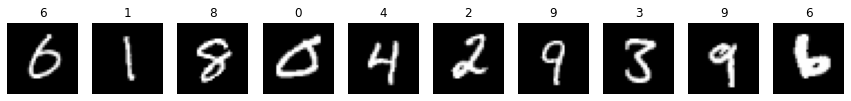

In [22]:
n_obs = 10
indices = np.random.choice(np.arange(X_test.shape[0]), n_obs, False)
obs = X_test[indices,:,:,:]

# Feed the model with the selected observations
predictions = np.argmin(my_model(obs), axis=1)

fig, ax = plt.subplots(nrows=1, ncols=n_obs, figsize=(15,6))

for i in range(n_obs):
  ax[i].imshow(obs[i,:,:,0], cmap='gray')
  ax[i].set_title(predictions[i])
  ax[i].axis('off')